In [70]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.preprocessing import normalize
import multiprocessing
from eunjeon import Mecab
import eunjeon
import konlpy
import textlib as tl
import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
MAX_VOCAB_SIZE = 10000
EMBEDDING_SIZE = 100
WORKERS = multiprocessing.cpu_count() - 1
WINDOW_SIZE = 5
EPOCHS = 10

UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
tokenizer = Mecab()

In [4]:
def make_w2v_model(in_file_name, out_file_name,
                   max_vocab_size=10000, embedding_size=100,
                   epochs=10, window=5, workers=3):
    # 빈도수 상위 vocab_size 내에 존재하는 단어 중 최소 빈도수를 구함
    def get_min_freq_count(sentences, max_freq_rank):
        from itertools import chain
        import nltk

        fdist = nltk.FreqDist(chain.from_iterable(sentences))
        return fdist.most_common(max_freq_rank)[-1][1] # the count of the the top-kth word

    # 단어 모음
    corpus = [sentence.strip().split(' ') 
              for sentence in open(in_file_name, 'r', encoding='utf-8').readlines()]
    # 빈도수 상위 n위의 최소빈도수 구함 (word2vec 훈련 시 그 이하는 버리기 위함)
    min_freq_cnt = get_min_freq_count(corpus, max_vocab_size)
    print(f'{max_vocab_size}개의 단어 내에서 최소 빈도수는 {min_freq_cnt}입니다.')
    
    loss_logger = LossLogger()
    # gensim word2vec call
    w2v_model = Word2Vec(corpus, 
                     size=embedding_size, 
                     workers=workers, 
                     min_count=min_freq_cnt,
                     sg=1, 
                     iter=epochs,
                     callbacks=[loss_logger],
                     compute_loss=True,
                     window=window)
    # 저장
    w2v_model.save(out_file_name)        
    
    return _post_w2v_process(w2v_model)

In [5]:
def _post_w2v_process(w2v_model):    
    # unknown, padding 토큰 추가
    def _append_unk_pad_vectors(embeddings):
        embedding_size = embeddings.shape[1]
        def get_truncated_normal(mean=0, sd=1, low=-1, upp=1):
            from scipy.stats import truncnorm
            return truncnorm(
                    (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

        return np.append(embeddings, 
                         get_truncated_normal().rvs(embedding_size * 2).reshape(2, embedding_size), axis=0)    
        
    index2word = w2v_model.wv.index2word
    # unk, pad 추가
    index2word.append( UNK_TOKEN )
    index2word.append( PAD_TOKEN )    
    
    w2v = w2v_model.wv.vectors
    # unk, pad에 해당하는 normal 초기화된 벡터 추가
    w2v = _append_unk_pad_vectors(w2v)
    # cosine유사도 체크를 위해 normalize
    unit_w2v = normalize(w2v, norm='l2', axis=1)

    # word를 index로 변환
    word2index = {w:i for i, w in enumerate(index2word)}
    # 사전. word를 vector로 변환
    dictionary = {w:v for w, v in zip(index2word, unit_w2v)}    
    
    return {
        'w2v_model'   : w2v_model, 
        'index2word'  : index2word, 
        'word2index'  : word2index,

        'weight'      : w2v,
        'norm_weight' : unit_w2v
    }

In [2]:
# 훈련 완료된 모델 있으면 로드해서 쓴다.
def load_w2v_model(model_file_name):
    w2v_model = Word2Vec.load(model_file_name)
    return _post_w2v_process(w2v_model)


In [3]:
corpora_file_name = 'D:/ml/TCL2021_telco_embedding/dataset/telco_corpora.dat'
w2v_model_file_name = f'D:/ml/TCL2021_telco_embedding/dataset/telco_w2v_'


In [7]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.loss_previous_step = 0

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f'Loss after epoch {self.epoch}: {loss - self.loss_previous_step}')
        self.epoch += 1
        self.loss_previous_step = loss        

In [8]:
V10000_E100_W3_E50 = 1
V10000_E100_W5_E50 = 2
V10000_E100_W7_E50 = 3
V10000_E200_W3_E50 = 4
V10000_E200_W5_E50 = 5
V10000_E200_W7_E50 = 6
V10000_E300_W3_E50 = 7
V10000_E300_W5_E50 = 8
V10000_E300_W7_E50 = 9

W2V_PARAMS = {
        'MAX_VOCAB_SIZE': 10000,
        'EMBEDDING_SIZE': [100,100,100,200,200,200,300,300,300],
        'WORKERS': multiprocessing.cpu_count() - 1,
        'WINDOW_SIZE' : [3,5,7,3,5,7,3,5,7],
        'EPOCHS': [40] * 9
}


In [ ]:

# word2vec 모델 만들고 저장. 그 외 필요한 값들 리턴

for i in range(9):
    print(f'---- {i} 시작!! ----')
    w2v_output = make_w2v_model(corpora_file_name, 
                       w2v_model_file_name + str(i), 
                       max_vocab_size=W2V_PARAMS['MAX_VOCAB_SIZE'], 
                       embedding_size=W2V_PARAMS['EMBEDDING_SIZE'][i],
                       epochs=W2V_PARAMS['EPOCHS'][i],
                       window=W2V_PARAMS['WINDOW_SIZE'][i],
                       workers=W2V_PARAMS['WORKERS'])

In [16]:
i = 4
w2v_output = load_w2v_model(w2v_model_file_name + str(i))

print( len(w2v_output['index2word']) )
print( len(w2v_output['word2index']) )
print( len(w2v_output['weight']) )

print( w2v_output['index2word'][200] )
print( w2v_output['word2index']['약정'] )
print( w2v_output['weight'][2583] )
print( w2v_output['norm_weight'][2583] )

10200
10200
10200
수납
61
[-0.38894704 -0.78709239 -0.02053949  0.62151766 -0.33143678 -0.02544569
  0.07091758 -0.3562322  -0.52939683  0.40070957  0.87280399 -0.07639448
 -0.09781729 -0.18247893  0.1706156  -1.10060918 -0.58792406  0.32846183
  0.19595687 -0.4454346  -0.09967719 -0.22310935  0.44823277 -0.50018883
 -0.2213427  -1.12691152 -0.59989506 -0.11076654 -0.26104647 -0.02383818
 -0.18732348 -0.20200886 -0.53583735  0.09798191  0.22117108 -0.38267761
  0.54427153  0.48541212 -0.30488947 -0.36332938 -0.33351392 -0.42168429
 -0.39778164 -0.04398736 -0.26803616  0.17191893  0.0527528   0.13514544
 -0.01780099 -0.00173888  0.32504752  0.19961201  0.08980254  0.15378655
 -0.16959786  0.12700802 -0.4056603  -0.36966175 -0.05062306  0.34314114
  0.20364581  0.32187688 -0.68602711 -0.15384008 -0.68501037 -0.31941959
  0.16834334 -0.65360111 -0.52228135 -0.11630941 -0.10295479 -0.82282418
 -0.57594323  0.0986051  -1.06641257  0.13343875  0.01571975  0.12699907
 -0.41564107 -0.13842064 -0

(10200, 200)


In [55]:
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2)
    loss_ax = axes[0]
    acc_ax = axes[1]

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower right')

    plt.show()    

In [9]:
# 훈련 완료된 모델 있으면 로드해서 쓴다.
def load_w2v_model(model_file_name):
    w2v_model = Word2Vec.load(model_file_name)

    return _post_w2v_process(w2v_model)

w2v_output = load_w2v_model(w2v_model_file_name)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout
from keras.preprocessing.sequence import pad_sequences

In [20]:
input_file_name = 'D:/ml/TCL2021_telco_embedding/dataset/sor_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')

# null 인 row가 하나라도 있으면 삭제
df.dropna(axis=0, inplace=True)


In [53]:
df.shape

(92197, 5)

In [30]:
# co(요청회사)가 SKT, SKB인 것만 추출. 너무 적은 표본도 삭제
df = df[ ((df['co'] == 'SKT') | (df['co'] == 'SKB')) & \
             (
                (df['label'] != 'Configuration') & 
                (df['label'] != 'EAI/EIGW') &
                (df['label'] != 'I/F 유틸') &
                (df['label'] != 'MTOKTOK') &
                (df['label'] != 'PPS 상품권') &
                (df['label'] != 'Utility') &
                (df['label'] != '고객상담') &
                (df['label'] != '접근 관리') &
                (df['label'] != '코드 관리')
             )
       ]

In [77]:
#lens = [len(s) for s in df['sentence'].values]
lens = [len(s) for s in X]

In [78]:
def avg(it):
    return sum(it) / len(it)

print( min(lens) )
print( max(lens) )
print( avg(lens) )

93
3522
384.6967471826632


In [31]:
df.groupby('label').count()

,req_ym,co,req_br,sentence
label,,,,
Billing/OSS,6699,6699,6699,6699
CC,6484,6484,6484,6484
CRM,24176,24176,24176,24176
CTC,1676,1676,1676,1676
Customer Care,11064,11064,11064,11064
ERP,5661,5661,5661,5661
OCEAN,35,35,35,35
OSS,5458,5458,5458,5458
PRM,2597,2597,2597,2597


In [32]:
# 첫 모델은 sentence와 label만 써보자
df_zip = df[ ['sentence', 'label'] ]

y = df_zip.pop('label')
X = df_zip.pop('sentence')

In [68]:
# 문자열로 되어 있는 label을 categorical value로 변환
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [75]:
from importlib import reload
reload(tl)

<module 'textlib' from 'd:\\ml\\TCL2021_telco_embedding\\textlib.py'>

In [76]:
# 전처리 테스트
print('--- raw sentence ---')
print( X[0] )
print()

print('클렌징된 sentence')
cleansed_text = tl.clean_text( X[0] )
print( cleansed_text )
print()

print('tokenized sentence')
tokenized_sentence = tl.segment_sentences(cleansed_text)
print( tokenized_sentence )
print()

print('corpora')
ignore_words = ['변경','요청']
corpora = ' '.join(tl.get_corpora(tokenized_sentence, ignore_words)).split(' ')
print(corpora)
print()

sequence = [w2v_output['word2index'][t] if t in w2v_output['word2index'] 
                                        else w2v_output['word2index'][ UNK_TOKEN ]
                                        for t in corpora]
print('word id')
print(sequence)
print()


print(y[0])
print(label_encoder.inverse_transform([y[100]]))


--- raw sentence ---
소속영업장 변경 요청(SKB사내유치본점 -＞ 엘에스통신-채널고객팀) . SR-1705-0886;- 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 ;변경이 어렵습니다.;- 유통지원센터에서 청약 등록 시, 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요청 함 . 요청유형:자료수정,요청유형상세:PRM,검토/승인자성명:홍도희,검토/승인자사번:1700,검토승인자기간:2017-05-31,요청내용:1. 변경 전 유통망 : SKB사내유치본점2. 변경 후 유통망 : 엘에스통신(E00901)3. 서비스번호 : 7276564018 또는 1670-84914. 고객 : 세종화재해상자동차손해사정(주)5. 담당 AM : 박성M6. 적용 시점 : 6월 지급 분부터 적용(5월 영업에 대한)

클렌징된 sentence
소속영업장 변경 요청 SKB사내유치본점 엘에스통신 채널고객팀 . SR 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 변경이 어렵습니다. 유통지원센터에서 청약 등록 시 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요청 함 . 요청유형 자료수정 요청유형상세 PRM 검토/승인자성명 홍도희 검토/승인자사번 검토승인자기간 요청내용 . 변경 전 유통망 SKB사내유치본점 . 변경 후 유통망 엘에스통신 E . 서비스번호 또는 . 고객 세종화재해상자동차손해사정 주 . 담당 AM 박성M . 적용 시점 월 지급 분부터 적용 월 영업에 대한 

tokenized sentence
['소속영업장 변경 요청 SKB사내유치본점 엘에스통신 채널고객팀', 'SR 해당 서비스번호로 개통이 됐다고 하는데 스윙에서 서비스 번호로 검색이 되지 않아서 변경이 어렵습니다', '유통지원센터에서 청약 등록 시 창리정보통신으로 등록했으나 스윙 이관후 확인 시 소속영업장이 금란텔레콤으로 되어 있어 변경 요청 함', '요청유형 자

In [91]:
# 문장 전처리
preprocessed_X = []
print(f'{len(X)} 개의 데이터 존재 확인!')
MAX_SENTENCE_LEN = 200
ignore_words = ['변경','요청']

for i, text in enumerate(X):
    try:
        # 클렌징
        cleansed_text = tl.clean_text(text)
    except TypeError:
        print(f'      {i+1} 번째 데이터에 문제가 있어 skip!')
        continue

    # 문장으로 분리하여 배열로 리턴
    sentences = tl.segment_sentences(cleansed_text)
    # 문장 배열을 입릭으로 받아 형태소로 쪼갠 뒤, 다시 하나의 문자열로 변환하여 저장
    corpora = ' '.join(tl.get_corpora(sentences, ignore_words)).split(' ')
    # 단어들을 id로 변환
    sequence = [w2v_output['word2index'][t] if t in w2v_output['word2index'] 
                                            else w2v_output['word2index'][ UNK_TOKEN ]
                                            for t in corpora]
    preprocessed_X.append(sequence)

    if i % 5000 == 0 and i > 0:
        print(f'      {i} 번째 데이터 처리 완료!')

print('WORD 2 ID 완료!')
preprocessed_X = pad_sequences( preprocessed_X, maxlen=MAX_SENTENCE_LEN, padding='post', value=w2v_output['word2index'][PAD_TOKEN] )
print('PADING 완료!')

92197 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
      70000 번째 데이터 처리 완료!
      75000 번째 데이터 처리 완료!
      80000 번째 데이터 처리 완료!
      85000 번째 데이터 처리 완료!
      90000 번째 데이터 처리 완료!
WORD 2 ID 완료!
PADING 완료!


In [92]:
X_train, X_test, y_train, y_test = \
    train_test_split(preprocessed_X, y, test_size=0.3, random_state=42, stratify=y)

In [93]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

64537
27660
64537
27660


In [82]:
index = 800
print( [w2v_output['index2word'][i] for i in X_train[index]] )
print( X_train[index] )
print( y_train[index] )
print( label_encoder.inverse_transform([y_train[index]]) )

['LTE', 'M', '선납', '개발', '첨부', '참조', '유형', 'Swing', '시스템', '자동', '유형', '상세', 'Swing', '시스템', '자동', '검토', '승인', '성명', '석중', '검토', '승인', '사', '번', '검토', '승인', '자기', '내용', '첨부', '참조', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
[  311    86   723    52    39   130     4    81    42   123     4    41
    81    42   123     2     1    12  1771     2     1     7    10     2
     1    14     5    39   130 101

In [49]:
class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        # (batch, )
        self.w1 = Dense(units, activation='tanh')
        self.w2 = Dense(1)    
        self.softmax_ = Softmax(axis=1)
        
    def call(self, x):
        # (batch, seq, embedding_dim*2) -> # (batch, seq, dec_units)
        x = self.w1(x)
        # (batch, seq, dec_units) -> # (batch, seq, 1)
        score = self.softmax_( self.w2(x) )

        return tf.squeeze( tf.matmul(tf.transpose(x, perm=[0, 2, 1]), score ), axis=-1 )

In [88]:
class MoviePosNegClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, 
                 batch_size, embedding_weights, apply_attention, train_embedding_layer, dropout, classes):
        super(MoviePosNegClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units, return_sequences=apply_attention) )
        self.fc1 = Dense(128, activation='relu')
        self.fc2 = Dense(classes, activation='softmax')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        
        self.attention = Attention(self.dec_units)
        self.embedding.trainable = train_embedding_layer
        self.apply_attention = apply_attention
        
    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)
        x = self.do1(x)
        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        
        # (batch, seq, embedding_dim*2) -> (batch, embedding_dim)        
        if self.apply_attention:
            x = self.attention(x)
        
        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        
        return x

In [60]:
def train_and_evaluate(vocab_size, embedding_dim, dec_units, epochs, batch_size, 
       weights, apply_attention, train_embedding_layer, dropout, classes):
    model = MoviePosNegClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        batch_size,
        weights,
        apply_attention,
        train_embedding_layer,
        dropout,
        classes
    )

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    plot_hist(history)
    
    return history, test_score

Epoch 1/10
807/807 [==============================] - 44s 49ms/step - loss: 1.6684 - accuracy: 0.5136 - val_loss: 0.8253 - val_accuracy: 0.7543
Epoch 2/10
807/807 [==============================] - 39s 48ms/step - loss: 0.8003 - accuracy: 0.7631 - val_loss: 0.7308 - val_accuracy: 0.7719
Epoch 3/10
807/807 [==============================] - 39s 48ms/step - loss: 0.7323 - accuracy: 0.7776 - val_loss: 0.6932 - val_accuracy: 0.7828
Epoch 4/10
807/807 [==============================] - 39s 48ms/step - loss: 0.6767 - accuracy: 0.7946 - val_loss: 0.6823 - val_accuracy: 0.7893
Epoch 5/10
807/807 [==============================] - 39s 48ms/step - loss: 0.6300 - accuracy: 0.8062 - val_loss: 0.6564 - val_accuracy: 0.7993
Epoch 6/10
807/807 [==============================] - 39s 48ms/step - loss: 0.6091 - accuracy: 0.8111 - val_loss: 0.6359 - val_accuracy: 0.8043
Epoch 7/10
807/807 [==============================] - 39s 48ms/step - loss: 0.5676 - accuracy: 0.8238 - val_loss: 0.6441 - val_accuracy:

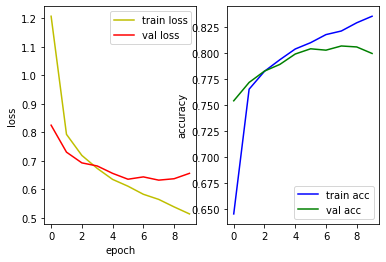

Epoch 1/10
807/807 [==============================] - 39s 43ms/step - loss: 1.5928 - accuracy: 0.5446 - val_loss: 0.8963 - val_accuracy: 0.7344
Epoch 2/10
807/807 [==============================] - 34s 42ms/step - loss: 0.8852 - accuracy: 0.7350 - val_loss: 0.8192 - val_accuracy: 0.7526
Epoch 3/10
807/807 [==============================] - 34s 42ms/step - loss: 0.7942 - accuracy: 0.7604 - val_loss: 0.7603 - val_accuracy: 0.7718
Epoch 4/10
807/807 [==============================] - 34s 42ms/step - loss: 0.7351 - accuracy: 0.7771 - val_loss: 0.7208 - val_accuracy: 0.7773
Epoch 5/10
807/807 [==============================] - 34s 42ms/step - loss: 0.6893 - accuracy: 0.7898 - val_loss: 0.7145 - val_accuracy: 0.7813
Epoch 6/10
807/807 [==============================] - 34s 42ms/step - loss: 0.6490 - accuracy: 0.8022 - val_loss: 0.7073 - val_accuracy: 0.7844
Epoch 7/10
807/807 [==============================] - 34s 42ms/step - loss: 0.6214 - accuracy: 0.8072 - val_loss: 0.6810 - val_accuracy:

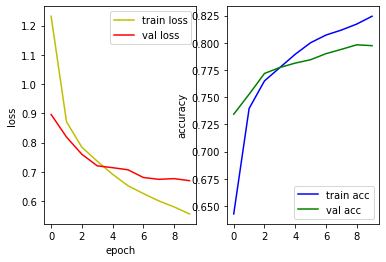

In [94]:
hyper_params = {
    'apply_attention': [True, False],
    'train_embedding_layer': [False],
    'dropout': [0.3],
    'weights': ['weight']#, 'norm_weight']
}

histories = dict()
test_scores = dict()

DEC_UNITS = 128
EPOCHS=10
BATCH_SIZE = 64

for a in hyper_params['apply_attention']:
    for ef in hyper_params['train_embedding_layer']:
        for do in hyper_params['dropout']:
            for w in hyper_params['weights']:
                for i in range(4,5):
                    w2v_output = load_w2v_model(w2v_model_file_name + str(i))
                    vocab_size, embedding_dim = w2v_output['weight'].shape
                    history, test_score = \
                        train_and_evaluate(vocab_size, 
                                           embedding_dim,
                                           DEC_UNITS,
                                           EPOCHS,
                                           BATCH_SIZE,
                                           w2v_output[w],
                                           a,
                                           ef,
                                           do,
                                           len(label_encoder.classes_))
                    model_name = f'{a}-{ef}-{do}-{w}-{i}'
                    histories[model_name] = history
                    test_scores[model_name] = test_score

In [95]:
test_scores


{'True-False-0.3-weight-4': [0.6471730470657349, 0.8102675080299377],
 'False-False-0.3-weight-4': [0.6649224162101746, 0.8021692037582397]}